In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
import torch
import pandas as pd
from tqdm import tqdm

In [ ]:
X_train = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/X_train.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/y_train.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/X_test.csv")
y_test = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/data/y_test.csv")

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

model_name = "tuner007/pegasus_paraphrase"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

def paraphrase_text(text, max_length=100):
    prompt = f"Rewrite the following differently: {text}"  # Prompt ekleyerek daha iyi sonuç alınabilir.

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)

    outputs = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        num_return_sequences=4,  # Çeşitli paraphrasing seçenekleri almak için
        do_sample=True,  # Sampling aktif edildi
        temperature=1.8,  # Çıktılarda çeşitlilik için sıcaklık artırıldı
        top_k=50,
        top_p=0.9,
        repetition_penalty=2.0,
        num_beams=5  # Beam search ile çeşitliliği artır
    )

    return [tokenizer.decode(output, skip_special_tokens=True).strip() for output in outputs]

# X_train veri setinde tüm metinler için paraphrasing işlemi
def generate_paraphrased_dataframe(X_train):
    data = []

    for text in tqdm(X_train, desc="Generating paraphrases"):
        paraphrased_texts = paraphrase_text(text)
        row = [text] + paraphrased_texts  # Orijinal + 4 paraphrased versiyon
        data.append(row)

    # DataFrame oluşturma
    df = pd.DataFrame(data, columns=['original', 'augmented_1', 'augmented_2', 'augmented_3', 'augmented_4'])
    return df

df_paraphrased = generate_paraphrased_dataframe(X_train.values.flatten())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating paraphrases: 100%|██████████| 80/80 [09:35<00:00,  7.20s/it]


In [ ]:
df_paraphrased.to_csv("/content/drive/MyDrive/Müş/LLM_Aug/pegasus_augmented.csv",index=False)

In [ ]:
import pandas as pd
df_paraphrased = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/pegasus_augmented.csv")

In [ ]:
df_paraphrased.iloc[1].values

array(['i love this tea for dieting its the best i will always purchase this tea for me and my family',
       'I love this tea, and will always purchase it for me and my family.',
       'I love this tea for dieting and will always buy it for me and my family.',
       'I love this tea, and will always purchase it for myself and my family.',
       'I love this tea, and will always purchase it for my family.'],
      dtype=object)

In [ ]:
df_paraphrased

,original,augmented_1,augmented_2,augmented_3,augmented_4
0,"They're ok, but not much flavor in the Sea Sal...",They're ok but not much flavor in the Sea Salt...,They're ok but not much flavor in the Sea Salt...,They're ok but not much flavor in the Sea Salt...,They're ok but not much flavor in the Sea Salt...
1,i love this tea for dieting its the best i wil...,"I love this tea, and will always purchase it f...",I love this tea for dieting and will always bu...,"I love this tea, and will always purchase it f...","I love this tea, and will always purchase it f..."
2,"Maybe I've prepared it wrong, but I haven't be...","I have prepared it wrong, so I've not been hap...","I have prepared it wrong, so I've not been hap...","I have prepared it wrong, so I've not been hap...","I have prepared it wrong, so I've not been hap..."
3,"A nice little gift, but it's not going to get ...",A nice little gift is not going to get you the...,A nice little gift is not going to get you the...,A nice little gift is not going to get you the...,A nice little gift is not going to get you the...
4,These cannoli shells are fantastic. Haven't f...,The cannoli shells are delicious and have yet ...,The cannoli shells are delicious and have yet ...,These cannoli shells are very good and have no...,These cannoli shells are very good and have no...
...,...,...,...,...,...
75,We love the taste but hardly any cookies are w...,I would have given them a 5 star rating.,I would have given them a 5 star rating if the...,I would have given them a 5 star rating if the...,I would have given them a 5 star rating if the...
76,Compact storage that do what they claim to do....,I would like to see a more economical version ...,I would like to see a more economical version ...,I would like to see a more economical version ...,I would like to see a more economical version ...
77,This horchata mix tastes nothing like horchata...,This horchata mix tastes nothing like horchata...,This horchata mix tastes nothing like horchata...,This horchata mix tastes nothing like horchata...,This horchata mix tastes nothing like horchata...
78,Great product - I wish you'd sell it in single...,The review process is very clumsy and the prod...,The review process is very clumsy and you shou...,The review process is very clumsy and you shou...,The review process is very clumsy and you shou...


In [ ]:
df_augmented = pd.read_csv("/content/drive/MyDrive/Müş/LLM_Aug/pegasus_augmented.csv")

In [ ]:
df_2x = pd.concat([df_augmented[['original']], df_augmented[['augmented_1']].rename(columns={"augmented_1": "original"})], ignore_index=True)
y_expanded = pd.concat([y_train, y_train], ignore_index=True)
# Yeni sütunu df_2x'e ekleyelim
df_2x["y"] = y_expanded.values
df_2x

,original,y
0,"They're ok, but not much flavor in the Sea Sal...",2
1,i love this tea for dieting its the best i wil...,4
2,"Maybe I've prepared it wrong, but I haven't be...",1
3,"A nice little gift, but it's not going to get ...",2
4,These cannoli shells are fantastic. Haven't f...,3
...,...,...
155,I would have given them a 5 star rating.,3
156,I would like to see a more economical version ...,3
157,This horchata mix tastes nothing like horchata...,0
158,The review process is very clumsy and the prod...,4


In [ ]:
df_3x = pd.concat([
    df_augmented[['original']],
    df_augmented[['augmented_1']].rename(columns={"augmented_1": "original"}),
    df_augmented[['augmented_2']].rename(columns={"augmented_2": "original"})
], ignore_index=True)

# y_train etiketlerini tekrarlayarak ekle
y_expanded = pd.concat([y_train, y_train, y_train], ignore_index=True)
df_3x["y"] = y_expanded.values
df_3x

,original,y
0,"They're ok, but not much flavor in the Sea Sal...",2
1,i love this tea for dieting its the best i wil...,4
2,"Maybe I've prepared it wrong, but I haven't be...",1
3,"A nice little gift, but it's not going to get ...",2
4,These cannoli shells are fantastic. Haven't f...,3
...,...,...
235,I would have given them a 5 star rating if the...,3
236,I would like to see a more economical version ...,3
237,This horchata mix tastes nothing like horchata...,0
238,The review process is very clumsy and you shou...,4


In [ ]:
df_5x = pd.concat([
    df_augmented[['original']],
    df_augmented[['augmented_1']].rename(columns={"augmented_1": "original"}),
    df_augmented[['augmented_2']].rename(columns={"augmented_2": "original"}),
    df_augmented[['augmented_3']].rename(columns={"augmented_3": "original"}),
    df_augmented[['augmented_4']].rename(columns={"augmented_4": "original"})
], ignore_index=True)

# y_train değerlerini 5 kez tekrar ederek ekle
y_expanded = pd.concat([y_train] * 5, ignore_index=True)

# Yeni y sütununu ekle
df_5x["y"] = y_expanded.values
df_5x

,original,y
0,"They're ok, but not much flavor in the Sea Sal...",2
1,i love this tea for dieting its the best i wil...,4
2,"Maybe I've prepared it wrong, but I haven't be...",1
3,"A nice little gift, but it's not going to get ...",2
4,These cannoli shells are fantastic. Haven't f...,3
...,...,...
395,I would have given them a 5 star rating if the...,3
396,I would like to see a more economical version ...,3
397,This horchata mix tastes nothing like horchata...,0
398,The review process is very clumsy and you shou...,4


In [ ]:
y_2x_train=df_2x["y"]
y_3x_train=df_3x["y"]
y_5x_train=df_5x["y"]

## Embeddings

In [ ]:
X_test_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(X_test["Text"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
X_original_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(X_train["Text"].tolist(),batch_size=32,show_progress_bar=True)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
X_2x_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(df_2x["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
X_3x_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(df_3x["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
X_5x_train_embeddings = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2").encode(df_5x["original"].tolist(),batch_size=32,show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

## Model Eğitimi

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:53:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Doğruluğu: 0.25
F1-Score: 0.22


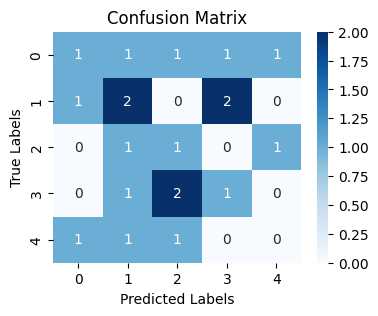

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.33      0.40      0.36         5
           2       0.20      0.33      0.25         3
           3       0.25      0.25      0.25         4
           4       0.00      0.00      0.00         3

    accuracy                           0.25        20
   macro avg       0.22      0.24      0.22        20
weighted avg       0.25      0.25      0.24        20



In [ ]:
#Original Data
# XGBoost modelini oluştur
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Çok sınıflı sınıflandırma için
    num_class=len(np.unique(y_train)), # Sınıf sayısını belirle
    eval_metric='mlogloss',      # Çok sınıflı log loss metriği
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Modeli eğit
xgb_model.fit(X_original_train_embeddings, y_train)
# Test seti ile tahmin yap
y_pred = xgb_model.predict(X_test_embeddings)

# Model doğruluğunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

f1score = f1_score(y_test, y_pred,average="macro")
print(f"F1-Score: {f1score:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sınıflandırma raporunu yazdır
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:53:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Doğruluğu: 0.35
F1-Score: 0.30


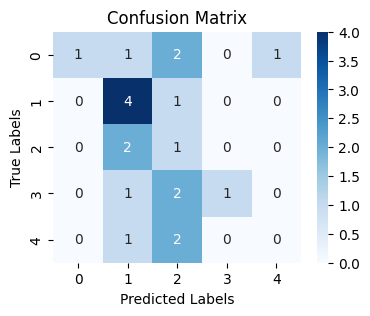

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.44      0.80      0.57         5
           2       0.12      0.33      0.18         3
           3       1.00      0.25      0.40         4
           4       0.00      0.00      0.00         3

    accuracy                           0.35        20
   macro avg       0.51      0.32      0.30        20
weighted avg       0.58      0.35      0.33        20



In [ ]:
#2x Data
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Çok sınıflı sınıflandırma için
    num_class=len(np.unique(y_train)), # Sınıf sayısını belirle
    eval_metric='mlogloss',      # Çok sınıflı log loss metriği
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Modeli eğit
xgb_model.fit(X_2x_train_embeddings, y_2x_train)
# Test seti ile tahmin yap
y_pred = xgb_model.predict(X_test_embeddings)

# Model doğruluğunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

f1score = f1_score(y_test, y_pred,average="macro")
print(f"F1-Score: {f1score:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sınıflandırma raporunu yazdır
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Doğruluğu: 0.35
F1-Score: 0.30


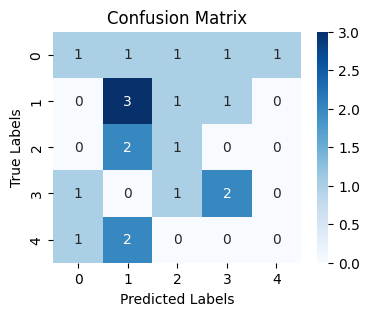

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.38      0.60      0.46         5
           2       0.25      0.33      0.29         3
           3       0.50      0.50      0.50         4
           4       0.00      0.00      0.00         3

    accuracy                           0.35        20
   macro avg       0.29      0.33      0.30        20
weighted avg       0.31      0.35      0.32        20



In [ ]:
#3x Data
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Çok sınıflı sınıflandırma için
    num_class=len(np.unique(y_train)), # Sınıf sayısını belirle
    eval_metric='mlogloss',      # Çok sınıflı log loss metriği
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Modeli eğit
xgb_model.fit(X_3x_train_embeddings, y_3x_train)
# Test seti ile tahmin yap
y_pred = xgb_model.predict(X_test_embeddings)

# Model doğruluğunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

f1score = f1_score(y_test, y_pred,average="macro")
print(f"F1-Score: {f1score:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sınıflandırma raporunu yazdır
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:54:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Doğruluğu: 0.40
F1-Score: 0.39


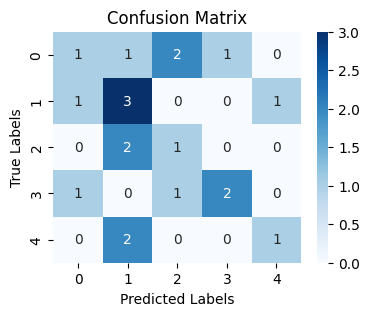

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.38      0.60      0.46         5
           2       0.25      0.33      0.29         3
           3       0.67      0.50      0.57         4
           4       0.50      0.33      0.40         3

    accuracy                           0.40        20
   macro avg       0.42      0.39      0.39        20
weighted avg       0.42      0.40      0.40        20



In [ ]:
#5x Data
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Çok sınıflı sınıflandırma için
    num_class=len(np.unique(y_train)), # Sınıf sayısını belirle
    eval_metric='mlogloss',      # Çok sınıflı log loss metriği
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    use_label_encoder=False
)

# Modeli eğit
xgb_model.fit(X_5x_train_embeddings, y_5x_train)
# Test seti ile tahmin yap
y_pred = xgb_model.predict(X_test_embeddings)

# Model doğruluğunu hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.2f}")

f1score = f1_score(y_test, y_pred,average="macro")
print(f"F1-Score: {f1score:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0","1","2","3","4"], yticklabels=["0","1","2","3","4"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sınıflandırma raporunu yazdır
print("Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))